In [1]:
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt 

## 데이터 불러오기

In [12]:
DATA_PATH =  "../[01]Data/"
datas = os.listdir(DATA_PATH)
print('CoREMOF_O2_15.0_5760.csv')
O2_15bar = pd.read_csv(os.path.join(DATA_PATH , 'CoREMOF_O2_15.0_5760.csv')).reset_index(drop = True).drop("Unnamed: 0", axis = 1)
O2_15bar  = O2_15bar[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
       'NASA_m2_cm3', 'NASA_m2_g', 'AV_VF', 'AV_cm3_g', 'NAV_cm3_g', 'Has_OMS',
       '0.5bar_GCMC',  'Uptake']]

CoREMOF_O2_15.0_5760.csv


Index(['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
       'NASA_m2_cm3', 'NASA_m2_g', 'AV_VF', 'AV_cm3_g', 'NAV_cm3_g', 'Has_OMS',
       '0.5bar_GCMC', 'Uptake'],
      dtype='object')

## 액티브 러닝 몬테카를로 드랍아웃
* 10개씩 추가 샘플링해가며 5%부터 학습

In [37]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch 모델 정의
class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DropoutMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Monte Carlo Dropout 예측 함수
def mc_dropout_predict(model, X, n_simulations):
    model.train()  # 드롭아웃 활성화를 위해 train 모드 유지
    predictions = []
    with torch.no_grad():  # 가중치 업데이트 방지
        for _ in range(n_simulations):
            predictions.append(model(X).detach().numpy())
    
    predictions = np.array(predictions)
    mean_prediction = predictions.mean(axis=0)
    uncertainty = predictions.std(axis=0)
    return mean_prediction, uncertainty

# 데이터 준비
data = pd.read_csv("../[01]Data/CoREMOF_O2_15.0_5760.csv").reset_index(drop=True).drop("Unnamed: 0", axis=1)
data = data[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
              'AV_VF', 'AV_cm3_g',  'Has_OMS',
             '0.5bar_GCMC', 'Uptake']]
# 'NASA_m2_cm3', 'NASA_m2_g', 'NAV_cm3_g' 제거

X = data.drop(['Adsorbent', 'Uptake'], axis=1)
y = data['Uptake']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train 데이터를 Initial (5%)와 Remaining (95%)으로 랜덤 분리
initial_size = int(0.05 * len(X_train))
indices = np.random.permutation(len(X_train))  # 데이터셋 인덱스를 랜덤으로 섞음
initial_indices = indices[:initial_size]  # 상위 5% 인덱스 선택
remaining_indices = indices[initial_size:]  # 나머지 인덱스 선택

X_initial = X_train.iloc[initial_indices]
y_initial = y_train.iloc[initial_indices]
X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns)
y_remaining = y_train.iloc[remaining_indices]
def create_dataloader(X, y, batch_size=32, shuffle=True):
    # y를 numpy 배열로 변환 (필요 시)
    if isinstance(y, pd.Series):
        y = y.to_numpy()
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

input_dim = X_train.shape[1]
hidden_dim = 64
# StandardScaler를 초기 데이터에 대해 피팅
scaler = StandardScaler()
X_initial_scaled = scaler.fit_transform(X_initial)
X_test_scaled = scaler.transform(X_test)

# 남은 데이터를 그대로 둠 (추후 transform 적용)
X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns)
y_remaining = y_train.iloc[remaining_indices].to_numpy()

# 초기 데이터 로더 생성
train_loader = create_dataloader(X_initial_scaled, y_initial)
test_loader = create_dataloader(X_test_scaled, y_test.to_numpy(), shuffle=False)

# 모델 초기화
model = DropoutMLP(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 초기 학습
epochs = 50
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

# 액티브 러닝 설정
iterations = 100
samples_per_iteration = 10
performance_log = []

# 초기 성능 평가
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
mean_prediction, _ = mc_dropout_predict(model, X_test_tensor, n_simulations=20)
mse = mean_squared_error(y_test, mean_prediction)
r2 = r2_score(y_test, mean_prediction)
performance_log.append((mse, r2))
print(f"Initial Test MSE: {mse}, R2: {r2}")

# 반복 학습
for iteration in range(iterations):
    # Monte Carlo Dropout 예측
    _, uncertainties = mc_dropout_predict(model, torch.tensor(scaler.transform(X_remaining), dtype=torch.float32), n_simulations=20)
    uncertainties = uncertainties.flatten()

    # 가장 불확실성이 높은 샘플 선택
    most_uncertain_indices = np.argsort(uncertainties)[-samples_per_iteration:]
    sampled_X = X_remaining.iloc[most_uncertain_indices].values
    sampled_y = y_remaining[most_uncertain_indices]

    # 선택된 샘플 추가
    X_initial = np.vstack([X_initial, sampled_X])
    y_initial = np.hstack([y_initial, sampled_y])

    # 남은 데이터에서 샘플 제거
    X_remaining = X_remaining.drop(X_remaining.index[most_uncertain_indices]).reset_index(drop=True)
    y_remaining = np.delete(y_remaining, most_uncertain_indices, axis=0)

    # 새 데이터 스케일링 및 로더 생성
    X_initial_scaled = scaler.transform(X_initial)
    train_loader = create_dataloader(X_initial_scaled, y_initial)

    # 모델 학습
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Test 성능 평가
    mean_prediction, _ = mc_dropout_predict(model, X_test_tensor, n_simulations=20)
    mse = mean_squared_error(y_test, mean_prediction)
    r2 = r2_score(y_test, mean_prediction)
    performance_log.append((mse, r2))
    print(f"Iteration {iteration + 1}/{iterations} - Test MSE: {mse}, R2: {r2}")

# 최종 성능 기록
print("Performance log:", performance_log)
first_log = performance_log


Initial Test MSE: 0.3311766345283599, R2: 0.7971701212710384


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 1/100 - Test MSE: 0.266878105500994, R2: 0.8365499007764504


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 2/100 - Test MSE: 0.25525489971139703, R2: 0.8436685594466284


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 3/100 - Test MSE: 0.23514238750621747, R2: 0.8559865130284715


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 4/100 - Test MSE: 0.1664384628771788, R2: 0.8980643870323464


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 5/100 - Test MSE: 0.1404958978174764, R2: 0.9139529696688338


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 6/100 - Test MSE: 0.13474879110686075, R2: 0.9174727981700705


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 7/100 - Test MSE: 0.12233238597111866, R2: 0.9250772535735104


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 8/100 - Test MSE: 0.1137522969889445, R2: 0.9303321484733771


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 9/100 - Test MSE: 0.11580979984296093, R2: 0.9290720261976647


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 10/100 - Test MSE: 0.11413357573660471, R2: 0.9300986334421613


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 11/100 - Test MSE: 0.10810058796246204, R2: 0.9337935504472372


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 12/100 - Test MSE: 0.10923323875167686, R2: 0.933099855910043


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 13/100 - Test MSE: 0.10721903792869487, R2: 0.9343334577589264


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 14/100 - Test MSE: 0.1053863641146237, R2: 0.9354558829807033


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 15/100 - Test MSE: 0.09554026989886327, R2: 0.9414861456487829


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 16/100 - Test MSE: 0.10030598917528309, R2: 0.9385673701008971


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 17/100 - Test MSE: 0.09709036306638223, R2: 0.9405367875830056


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 18/100 - Test MSE: 0.09778574089666774, R2: 0.9401109018583425


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 19/100 - Test MSE: 0.10868014363138173, R2: 0.933438600267219


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 20/100 - Test MSE: 0.10304867541183314, R2: 0.9368876057131006


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 21/100 - Test MSE: 0.1030603923840565, R2: 0.9368804296269659


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 22/100 - Test MSE: 0.10033777012446413, R2: 0.9385479057867028


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 23/100 - Test MSE: 0.09521155764738504, R2: 0.9416874662105399


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 24/100 - Test MSE: 0.0918570524454482, R2: 0.9437419405072351


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 25/100 - Test MSE: 0.0934654890710915, R2: 0.9427568498585936


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 26/100 - Test MSE: 0.09761292698955817, R2: 0.9402167421265475


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 27/100 - Test MSE: 0.09375546352032504, R2: 0.9425792543514218


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 28/100 - Test MSE: 0.09385827618724757, R2: 0.9425162865010678


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 29/100 - Test MSE: 0.1001296004697378, R2: 0.9386753997624879


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 30/100 - Test MSE: 0.09725161602163, R2: 0.940438027845912


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 31/100 - Test MSE: 0.09140831352215256, R2: 0.9440167716755711


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 32/100 - Test MSE: 0.09631184478092991, R2: 0.9410135928674469


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 33/100 - Test MSE: 0.08948919013914841, R2: 0.9451921431313351


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 34/100 - Test MSE: 0.08942707669327882, R2: 0.9452301846517194


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 35/100 - Test MSE: 0.0976146120716619, R2: 0.9402157100942025


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 36/100 - Test MSE: 0.09256202622382285, R2: 0.9433101777224647


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 37/100 - Test MSE: 0.09570973325056564, R2: 0.9413823574358139


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 38/100 - Test MSE: 0.0889960242712546, R2: 0.945494183682356


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 39/100 - Test MSE: 0.09545447511961853, R2: 0.9415386908553449


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 40/100 - Test MSE: 0.09496576169413545, R2: 0.9418380044979426


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 41/100 - Test MSE: 0.09233949431917342, R2: 0.9434464678906938


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 42/100 - Test MSE: 0.08627440241394216, R2: 0.9471610471434542


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 43/100 - Test MSE: 0.09157078722367869, R2: 0.9439172642896587


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 44/100 - Test MSE: 0.08802353149190127, R2: 0.9460897890842345


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 45/100 - Test MSE: 0.08914514484484419, R2: 0.9454028544498446


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 46/100 - Test MSE: 0.08660887020852133, R2: 0.9469562015863096


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 47/100 - Test MSE: 0.08873153099065247, R2: 0.9456561731901773


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 48/100 - Test MSE: 0.0963293542930146, R2: 0.9410028691271751


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 49/100 - Test MSE: 0.09735668136078487, R2: 0.9403736803413553


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 50/100 - Test MSE: 0.08937476789558989, R2: 0.9452622212931534


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 51/100 - Test MSE: 0.10108839445655546, R2: 0.938088184217076


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 52/100 - Test MSE: 0.08708825526673797, R2: 0.946662601123339


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 53/100 - Test MSE: 0.09250619197227627, R2: 0.9433443735360862


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 54/100 - Test MSE: 0.0896987234312171, R2: 0.945063813992776


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 55/100 - Test MSE: 0.08584468166796272, R2: 0.9474242305860857


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 56/100 - Test MSE: 0.08542131449409639, R2: 0.9476835227691089


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 57/100 - Test MSE: 0.08705761131197826, R2: 0.9466813690827288


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 58/100 - Test MSE: 0.09214989755842183, R2: 0.9435625868555639


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 59/100 - Test MSE: 0.09142283712279128, R2: 0.9440078766635167


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 60/100 - Test MSE: 0.08617321815836235, R2: 0.9472230176695988


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 61/100 - Test MSE: 0.08175323167944445, R2: 0.9499300483838257


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 62/100 - Test MSE: 0.1005851090294711, R2: 0.9383964225150071


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 63/100 - Test MSE: 0.08553438151599262, R2: 0.9476142746158626


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 64/100 - Test MSE: 0.09231176766875294, R2: 0.9434634491404439


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 65/100 - Test MSE: 0.09073854360163278, R2: 0.9444269737779893


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 66/100 - Test MSE: 0.08785375410950776, R2: 0.9461937696260104


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 67/100 - Test MSE: 0.0849547311255938, R2: 0.9479692828082649


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 68/100 - Test MSE: 0.08461248497238141, R2: 0.9481788922387441


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 69/100 - Test MSE: 0.08389438896542495, R2: 0.9486186917620835


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 70/100 - Test MSE: 0.08277795171052292, R2: 0.9493024562835232


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 71/100 - Test MSE: 0.08278915224433249, R2: 0.9492955964912629


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 72/100 - Test MSE: 0.08090555156377127, R2: 0.9504492119875859


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 73/100 - Test MSE: 0.08258708497397302, R2: 0.9494193530479429


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 74/100 - Test MSE: 0.08702132369303633, R2: 0.9467035935170094


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 75/100 - Test MSE: 0.08035645459441641, R2: 0.9507855076681774


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 76/100 - Test MSE: 0.08408129912224187, R2: 0.9485042182138684


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 77/100 - Test MSE: 0.08813727570055879, R2: 0.9460201261864247


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 78/100 - Test MSE: 0.09262819341221605, R2: 0.943269653478305


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 79/100 - Test MSE: 0.08065434253989955, R2: 0.9506030655223321


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 80/100 - Test MSE: 0.08794858367583161, R2: 0.9461356910436709


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 81/100 - Test MSE: 0.08474602496386274, R2: 0.9480971053689783


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 82/100 - Test MSE: 0.08097043230629411, R2: 0.9504094756301087


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 83/100 - Test MSE: 0.08330809802514781, R2: 0.9489777669742755


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 84/100 - Test MSE: 0.07827505103311483, R2: 0.9520602679861149


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 85/100 - Test MSE: 0.08967460924360905, R2: 0.9450785827815076


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 86/100 - Test MSE: 0.0866592610264185, R2: 0.9469253396159363


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 87/100 - Test MSE: 0.08279947579451191, R2: 0.9492892738096103


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 88/100 - Test MSE: 0.07964049849286134, R2: 0.9512239966016146


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 89/100 - Test MSE: 0.08401722343084032, R2: 0.948543461515966


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 90/100 - Test MSE: 0.08246062636779741, R2: 0.9494968029072646


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 91/100 - Test MSE: 0.08151466951090092, R2: 0.9500761563234269


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 92/100 - Test MSE: 0.08193848184500307, R2: 0.9498165915010106


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 93/100 - Test MSE: 0.08466053777492039, R2: 0.948149462191164


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 94/100 - Test MSE: 0.08190390897987548, R2: 0.94983776573044


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 95/100 - Test MSE: 0.08621168281450839, R2: 0.9471994599039594


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 96/100 - Test MSE: 0.08450231324805425, R2: 0.948246367160447


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 97/100 - Test MSE: 0.07978688867175344, R2: 0.9511343396055102


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 98/100 - Test MSE: 0.07921065248818955, R2: 0.9514872567592156


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 99/100 - Test MSE: 0.0813613726066239, R2: 0.950170043359112


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100/100 - Test MSE: 0.08290403481513339, R2: 0.9492252364009842
Performance log: [(0.3311766345283599, 0.7971701212710384), (0.266878105500994, 0.8365499007764504), (0.25525489971139703, 0.8436685594466284), (0.23514238750621747, 0.8559865130284715), (0.1664384628771788, 0.8980643870323464), (0.1404958978174764, 0.9139529696688338), (0.13474879110686075, 0.9174727981700705), (0.12233238597111866, 0.9250772535735104), (0.1137522969889445, 0.9303321484733771), (0.11580979984296093, 0.9290720261976647), (0.11413357573660471, 0.9300986334421613), (0.10810058796246204, 0.9337935504472372), (0.10923323875167686, 0.933099855910043), (0.10721903792869487, 0.9343334577589264), (0.1053863641146237, 0.9354558829807033), (0.09554026989886327, 0.9414861456487829), (0.10030598917528309, 0.9385673701008971), (0.09709036306638223, 0.9405367875830056), (0.09778574089666774, 0.9401109018583425), (0.10868014363138173, 0.933438600267219), (0.10304867541183314, 0.9368876057131006), (0.10306039238

## 랜덤하게 샘플링해서 추가

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch 모델 정의
class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DropoutMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# 데이터 준비
data = pd.read_csv("../[01]Data/CoREMOF_O2_15.0_5760.csv").reset_index(drop=True).drop("Unnamed: 0", axis=1)
data = data[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
              'AV_VF', 'AV_cm3_g',  'Has_OMS',
             '0.5bar_GCMC', 'Uptake']]
X = data.drop(['Adsorbent', 'Uptake'], axis=1)
y = data['Uptake']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Train 데이터를 Initial (5%)와 Remaining (95%)으로 랜덤 분리
initial_size = int(0.05 * len(X_train))
indices = np.random.permutation(len(X_train))
initial_indices = indices[:initial_size]
remaining_indices = indices[initial_size:]

X_initial = X_train.iloc[initial_indices]
y_initial = y_train.iloc[initial_indices].to_numpy()

# 스탠다드 스케일러 적용
scaler = StandardScaler()
X_initial_scaled = scaler.fit_transform(X_initial)
X_test_scaled = scaler.transform(X_test)
X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns).reset_index(drop =True)
y_remaining = y_train.iloc[remaining_indices].reset_index(drop =True)

def create_dataloader(X, y, batch_size=32, shuffle=True):
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(X_initial_scaled, y_initial)
test_loader = create_dataloader(X_test_scaled, y_test.to_numpy(), shuffle=False)

# 모델 초기화
input_dim = X_train.shape[1]
hidden_dim = 64
model = DropoutMLP(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 초기 모델 학습
epochs = 50
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

# 랜덤 샘플링 설정
iterations = 100
samples_per_iteration = 10
performance_log = []

X_remaining_tensor = torch.tensor(X_remaining.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# 초기 Test 성능 평가
mean_prediction, _ = mc_dropout_predict(model, X_test_tensor, n_simulations=20)
mse = mean_squared_error(y_test, mean_prediction)
r2 = r2_score(y_test, mean_prediction)
performance_log.append((mse, r2))
print(f"Initial Test MSE: {mse}, R2: {r2}")

for iteration in range(iterations):
    # 랜덤으로 샘플 선택
    sample_indices = np.random.choice(X_remaining.index, size=samples_per_iteration, replace=False)
    sample_indices = X_remaining.index[sample_indices]  # 현재 인덱스 동기화
    sampled_X = X_remaining.iloc[sample_indices].values
    sampled_y = y_remaining.iloc[sample_indices].to_numpy()

    # 선택된 샘플을 Training Set에 추가
    X_initial = np.vstack([X_initial, sampled_X])
    y_initial = np.hstack([y_initial, sampled_y])
    X_initial_scaled = scaler.transform(X_initial)
    # 남은 데이터에서 선택된 샘플 제거
    X_remaining = X_remaining.drop(sample_indices).reset_index(drop=True)  # 인덱스 초기화
    y_remaining = y_remaining.drop(sample_indices).reset_index(drop=True)  # 인덱스 초기화


    # 새 학습 데이터로 DataLoader 생성
    train_loader = create_dataloader(X_initial_scaled, y_initial)

    # 모델 재학습
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Test 성능 평가
    mean_prediction, _ = mc_dropout_predict(model, X_test_tensor, n_simulations=20)
    mse = mean_squared_error(y_test, mean_prediction)
    r2 = r2_score(y_test, mean_prediction)
    performance_log.append((mse, r2))
    print(f"Iteration {iteration + 1}/{iterations} - Test MSE: {mse}, R2: {r2}")

# 성능 기록 출력
print("Performance log:", performance_log)
second_log = performance_log


Initial Test MSE: 0.9104599920737885, R2: 0.44238671896980086


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 1/100 - Test MSE: 0.6779104483897381, R2: 0.5848122128790703


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 2/100 - Test MSE: 0.43609012077022224, R2: 0.732915619374265


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 3/100 - Test MSE: 0.49294931180047985, R2: 0.6980920792482588


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 4/100 - Test MSE: 0.24698568482358402, R2: 0.8487330588044031


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 5/100 - Test MSE: 0.2412033981073798, R2: 0.8522744333796175


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 6/100 - Test MSE: 0.25097369907872896, R2: 0.846290590455474


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 7/100 - Test MSE: 0.23015553548829637, R2: 0.8590407218239522


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 8/100 - Test MSE: 0.19477568239729284, R2: 0.8807091928563862


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 9/100 - Test MSE: 0.19436844960898506, R2: 0.8809586034984882


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 10/100 - Test MSE: 0.1664919858376893, R2: 0.8980316067741467


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 11/100 - Test MSE: 0.21955401049136283, R2: 0.8655336497822679


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 12/100 - Test MSE: 0.19257127793427015, R2: 0.882059285354733


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 13/100 - Test MSE: 0.1839286400960242, R2: 0.8873524884429468


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 14/100 - Test MSE: 0.1744961143166721, R2: 0.8931294601869179


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 15/100 - Test MSE: 0.21686116610705958, R2: 0.8671828884149452


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 16/100 - Test MSE: 0.19132572133770182, R2: 0.8828221293089624


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 17/100 - Test MSE: 0.18218000573159507, R2: 0.8884234435137462


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 18/100 - Test MSE: 0.18632195188276712, R2: 0.8858866992269986


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 19/100 - Test MSE: 0.15737208955387072, R2: 0.9036171078766081


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 20/100 - Test MSE: 0.21121361345581124, R2: 0.870641744807394


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 21/100 - Test MSE: 0.17565757943484858, R2: 0.8924181182487912


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 22/100 - Test MSE: 0.18091980746439906, R2: 0.8891952547922618


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 23/100 - Test MSE: 0.18164217920058812, R2: 0.8887528365888848


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 24/100 - Test MSE: 0.2117860927052546, R2: 0.8702911285964865


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 25/100 - Test MSE: 0.16820136747211556, R2: 0.8969846921266023


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 26/100 - Test MSE: 0.16118140209768178, R2: 0.9012840857948956


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 27/100 - Test MSE: 0.23207057926607058, R2: 0.8578678489316367


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 28/100 - Test MSE: 0.2008507218517462, R2: 0.8769885212046096


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 29/100 - Test MSE: 0.16766422273088202, R2: 0.8973136676380524


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 30/100 - Test MSE: 0.15462096048634463, R2: 0.9053020430953282


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 31/100 - Test MSE: 0.16965146276637988, R2: 0.8960965779844318


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 32/100 - Test MSE: 0.18652801840801175, R2: 0.8857604933176204


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 33/100 - Test MSE: 0.18161508628418419, R2: 0.8887694297068035


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 34/100 - Test MSE: 0.2731756866701606, R2: 0.8326929329482491


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 35/100 - Test MSE: 0.2366753997053786, R2: 0.8550476162403914


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 36/100 - Test MSE: 0.23767007926908634, R2: 0.8544384224922625


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 37/100 - Test MSE: 0.19101221065466206, R2: 0.8830141396357529


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 38/100 - Test MSE: 0.21273361158376408, R2: 0.869710818516655


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 39/100 - Test MSE: 0.2288354925288386, R2: 0.8598491851195743


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 40/100 - Test MSE: 0.23095167648680276, R2: 0.8585531234690497


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 41/100 - Test MSE: 0.21227070176596421, R2: 0.8699943286813757


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 42/100 - Test MSE: 0.20468564465544548, R2: 0.8746398140613143


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 43/100 - Test MSE: 0.2556492420367216, R2: 0.8434270435977306


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 44/100 - Test MSE: 0.22829504677638982, R2: 0.8601801823428081


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 45/100 - Test MSE: 0.25921030488546243, R2: 0.8412460626031476


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 46/100 - Test MSE: 0.2617883311779408, R2: 0.8396671445704544


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 47/100 - Test MSE: 0.22685307472858465, R2: 0.8610633213843151


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 48/100 - Test MSE: 0.24535919425424074, R2: 0.8497292066316903


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 49/100 - Test MSE: 0.2222913861372128, R2: 0.8638571378777549


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 50/100 - Test MSE: 0.32202725357427364, R2: 0.8027736803264809


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 51/100 - Test MSE: 0.2096485676583113, R2: 0.8716002606452166


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 52/100 - Test MSE: 0.25540044312838783, R2: 0.8435794210517653


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 53/100 - Test MSE: 0.22178498958933798, R2: 0.8641672815886495


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 54/100 - Test MSE: 0.21312321984087518, R2: 0.8694722020585399


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 55/100 - Test MSE: 0.23218861933278973, R2: 0.8577955550258426


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 56/100 - Test MSE: 0.275801304607126, R2: 0.8310848673052676


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 57/100 - Test MSE: 0.23120416209661265, R2: 0.8583984880863589


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 58/100 - Test MSE: 0.17772531131848426, R2: 0.891151731180757


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 59/100 - Test MSE: 0.23181646916235601, R2: 0.858023479239293


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 60/100 - Test MSE: 0.2065013604444309, R2: 0.8735277748203496


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 61/100 - Test MSE: 0.20846013853412956, R2: 0.8723281167497966


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 62/100 - Test MSE: 0.29827071538984107, R2: 0.8173234258597992


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 63/100 - Test MSE: 0.1903977996452183, R2: 0.8833904370478959


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 64/100 - Test MSE: 0.1801280759595853, R2: 0.8896801525427809


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 65/100 - Test MSE: 0.19216375678649, R2: 0.882308872603246


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 66/100 - Test MSE: 0.18084168672043496, R2: 0.8892431000185623


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 67/100 - Test MSE: 0.20754259276112508, R2: 0.8728900697333813


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 68/100 - Test MSE: 0.14485576231507172, R2: 0.9112827607980258


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 69/100 - Test MSE: 0.24469464769946717, R2: 0.8501362096719454


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 70/100 - Test MSE: 0.31250170274760136, R2: 0.808607625471047


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 71/100 - Test MSE: 0.20215495989989074, R2: 0.8761897376626621


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 72/100 - Test MSE: 0.1999034313761298, R2: 0.8775686913985727


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 73/100 - Test MSE: 0.21826758922969336, R2: 0.8663215213930486


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 74/100 - Test MSE: 0.16682131062246247, R2: 0.897829911064988


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 75/100 - Test MSE: 0.20734768246577895, R2: 0.8730094429845299


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 76/100 - Test MSE: 0.1716237656293717, R2: 0.8948886366358909


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 77/100 - Test MSE: 0.1973271031007196, R2: 0.8791465694768726


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 78/100 - Test MSE: 0.22713788499916587, R2: 0.8608888886900369


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 79/100 - Test MSE: 0.1837801590957964, R2: 0.8874434259673064


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 80/100 - Test MSE: 0.2542745082773969, R2: 0.8442690023974072


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 81/100 - Test MSE: 0.3790333485195862, R2: 0.7678601685654957


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 82/100 - Test MSE: 0.2658430322603283, R2: 0.837183833723377


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 83/100 - Test MSE: 0.3302453823130522, R2: 0.797740468796207


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 84/100 - Test MSE: 0.19367258174959973, R2: 0.8813847893425817


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 85/100 - Test MSE: 0.17636653039985178, R2: 0.8919839196270765


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 86/100 - Test MSE: 0.2684614626660238, R2: 0.8355801701001755


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 87/100 - Test MSE: 0.1940571804862708, R2: 0.8811492409765884


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 88/100 - Test MSE: 0.24650640196108586, R2: 0.8490265966773748


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 89/100 - Test MSE: 0.2217822350056094, R2: 0.8641689686396832


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 90/100 - Test MSE: 0.3050616764636173, R2: 0.8131642863933065


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 91/100 - Test MSE: 0.23954047979883222, R2: 0.8532928914581568


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 92/100 - Test MSE: 0.24014826323985167, R2: 0.8529206531152828


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 93/100 - Test MSE: 0.23725472477702342, R2: 0.8546928072901957


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 94/100 - Test MSE: 0.18111306111661007, R2: 0.8890768961559476


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 95/100 - Test MSE: 0.18545685413116944, R2: 0.8864165303012685


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 96/100 - Test MSE: 0.1816344573476788, R2: 0.8887575658551611


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 97/100 - Test MSE: 0.22042039029425223, R2: 0.8650030335127852


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 98/100 - Test MSE: 0.24180734098875314, R2: 0.8519045471961836


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 99/100 - Test MSE: 0.1591871060375061, R2: 0.9025054969267864


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100/100 - Test MSE: 0.2503859902284842, R2: 0.846650534069832
Performance log: [(0.9104599920737885, 0.44238671896980086), (0.6779104483897381, 0.5848122128790703), (0.43609012077022224, 0.732915619374265), (0.49294931180047985, 0.6980920792482588), (0.24698568482358402, 0.8487330588044031), (0.2412033981073798, 0.8522744333796175), (0.25097369907872896, 0.846290590455474), (0.23015553548829637, 0.8590407218239522), (0.19477568239729284, 0.8807091928563862), (0.19436844960898506, 0.8809586034984882), (0.1664919858376893, 0.8980316067741467), (0.21955401049136283, 0.8655336497822679), (0.19257127793427015, 0.882059285354733), (0.1839286400960242, 0.8873524884429468), (0.1744961143166721, 0.8931294601869179), (0.21686116610705958, 0.8671828884149452), (0.19132572133770182, 0.8828221293089624), (0.18218000573159507, 0.8884234435137462), (0.18632195188276712, 0.8858866992269986), (0.15737208955387072, 0.9036171078766081), (0.21121361345581124, 0.870641744807394), (0.1756575794348

## 랜덤 샘플링이면서 매번 아예 새로운 모델을 학습시키는 코드

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch 모델 정의
class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DropoutMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# 데이터 준비
data = pd.read_csv("../[01]Data/CoREMOF_O2_15.0_5760.csv").reset_index(drop=True).drop("Unnamed: 0", axis=1)
data = data[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
              'AV_VF', 'AV_cm3_g',  'Has_OMS',
             '0.5bar_GCMC', 'Uptake']]
X = data.drop(['Adsorbent', 'Uptake'], axis=1)
y = data['Uptake']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train 데이터를 Initial (5%)와 Remaining (95%)으로 랜덤 분리
initial_size = int(0.05 * len(X_train))
indices = np.random.permutation(len(X_train))
initial_indices = indices[:initial_size]
remaining_indices = indices[initial_size:]

X_initial = X_train.iloc[initial_indices]
y_initial = y_train.iloc[initial_indices].to_numpy()

# 스탠다드 스케일러 적용
scaler = StandardScaler()
X_initial_scaled = scaler.fit_transform(X_initial)
X_test_scaled = scaler.transform(X_test)
X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns).reset_index(drop=True)
y_remaining = y_train.iloc[remaining_indices].reset_index(drop=True)

def create_dataloader(X, y, batch_size=32, shuffle=True):
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(X_initial_scaled, y_initial)
test_loader = create_dataloader(X_test_scaled, y_test.to_numpy(), shuffle=False)

# 모델 초기화
input_dim = X_train.shape[1]
hidden_dim = 64
criterion = nn.MSELoss()

# 랜덤 샘플링 설정
iterations = 100
samples_per_iteration = 10
performance_log = []

for iteration in range(iterations):
    # 랜덤으로 샘플 선택
    sample_indices = np.random.choice(X_remaining.index, size=samples_per_iteration, replace=False)
    sampled_X = X_remaining.iloc[sample_indices].values
    sampled_y = y_remaining.iloc[sample_indices].to_numpy()

    # 선택된 샘플을 Training Set에 추가
    X_initial = np.vstack([X_initial, sampled_X])
    y_initial = np.hstack([y_initial, sampled_y])

    # 남은 데이터에서 선택된 샘플 제거
    X_remaining = X_remaining.drop(sample_indices).reset_index(drop=True)
    y_remaining = y_remaining.drop(sample_indices).reset_index(drop=True)

    # 새 데이터 스케일링
    scaler = StandardScaler()
    X_initial_scaled = scaler.fit_transform(X_initial)
    X_test_scaled = scaler.transform(X_test)
    train_loader = create_dataloader(X_initial_scaled, y_initial)

    # 새로운 모델 생성
    model = DropoutMLP(input_dim, hidden_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 모델 학습
    epochs = 50
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Test 성능 평가
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).squeeze().numpy()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    performance_log.append((mse, r2))

    print(f"Iteration {iteration + 1}/{iterations} - Samples: {len(y_initial)}, Test MSE: {mse:.4f}, R2: {r2:.4f}")

# 성능 기록 출력
print("Performance log:")
for entry in performance_log:
    print(f"MSE: {entry[0]:.4f}, R2: {entry[1]:.4f}")
third_log = performance_log

c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 1/100 - Samples: 240, Test MSE: 1.2803, R2: 0.2159


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 2/100 - Samples: 250, Test MSE: 0.9608, R2: 0.4115


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 3/100 - Samples: 260, Test MSE: 1.0038, R2: 0.3852


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 4/100 - Samples: 270, Test MSE: 1.0257, R2: 0.3718


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 5/100 - Samples: 280, Test MSE: 0.9103, R2: 0.4425


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 6/100 - Samples: 290, Test MSE: 0.6251, R2: 0.6171


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 7/100 - Samples: 300, Test MSE: 0.8091, R2: 0.5045


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 8/100 - Samples: 310, Test MSE: 0.7707, R2: 0.5280


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 9/100 - Samples: 320, Test MSE: 1.1211, R2: 0.3134


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 10/100 - Samples: 330, Test MSE: 0.7489, R2: 0.5413


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 11/100 - Samples: 340, Test MSE: 0.6889, R2: 0.5781


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 12/100 - Samples: 350, Test MSE: 0.5979, R2: 0.6338


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 13/100 - Samples: 360, Test MSE: 0.4914, R2: 0.6991


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 14/100 - Samples: 370, Test MSE: 0.5111, R2: 0.6870


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 15/100 - Samples: 380, Test MSE: 0.5643, R2: 0.6544


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 16/100 - Samples: 390, Test MSE: 0.5723, R2: 0.6495


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 17/100 - Samples: 400, Test MSE: 0.4314, R2: 0.7358


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 18/100 - Samples: 410, Test MSE: 0.3121, R2: 0.8088


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 19/100 - Samples: 420, Test MSE: 0.3949, R2: 0.7581


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 20/100 - Samples: 430, Test MSE: 0.4838, R2: 0.7037


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 21/100 - Samples: 440, Test MSE: 0.3665, R2: 0.7756


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 22/100 - Samples: 450, Test MSE: 0.4387, R2: 0.7313


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 23/100 - Samples: 460, Test MSE: 0.2681, R2: 0.8358


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 24/100 - Samples: 470, Test MSE: 0.4826, R2: 0.7044


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 25/100 - Samples: 480, Test MSE: 0.4057, R2: 0.7515


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 26/100 - Samples: 490, Test MSE: 0.3714, R2: 0.7726


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 27/100 - Samples: 500, Test MSE: 0.3565, R2: 0.7817


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 28/100 - Samples: 510, Test MSE: 0.4024, R2: 0.7535


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 29/100 - Samples: 520, Test MSE: 0.3679, R2: 0.7747


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 30/100 - Samples: 530, Test MSE: 0.3493, R2: 0.7861


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 31/100 - Samples: 540, Test MSE: 0.3489, R2: 0.7863


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 32/100 - Samples: 550, Test MSE: 0.2925, R2: 0.8208


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 33/100 - Samples: 560, Test MSE: 0.3548, R2: 0.7827


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 34/100 - Samples: 570, Test MSE: 0.2914, R2: 0.8215


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 35/100 - Samples: 580, Test MSE: 0.1859, R2: 0.8861


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 36/100 - Samples: 590, Test MSE: 0.2244, R2: 0.8626


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 37/100 - Samples: 600, Test MSE: 0.1776, R2: 0.8912


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 38/100 - Samples: 610, Test MSE: 0.1799, R2: 0.8898


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 39/100 - Samples: 620, Test MSE: 0.2261, R2: 0.8615


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 40/100 - Samples: 630, Test MSE: 0.2261, R2: 0.8615


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 41/100 - Samples: 640, Test MSE: 0.2136, R2: 0.8692


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 42/100 - Samples: 650, Test MSE: 0.2378, R2: 0.8543


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 43/100 - Samples: 660, Test MSE: 0.3231, R2: 0.8021


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 44/100 - Samples: 670, Test MSE: 0.2515, R2: 0.8460


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 45/100 - Samples: 680, Test MSE: 0.2140, R2: 0.8690


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 46/100 - Samples: 690, Test MSE: 0.1788, R2: 0.8905


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 47/100 - Samples: 700, Test MSE: 0.2730, R2: 0.8328


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 48/100 - Samples: 710, Test MSE: 0.1630, R2: 0.9001


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 49/100 - Samples: 720, Test MSE: 0.2253, R2: 0.8620


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 50/100 - Samples: 730, Test MSE: 0.1796, R2: 0.8900


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 51/100 - Samples: 740, Test MSE: 0.1973, R2: 0.8792


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 52/100 - Samples: 750, Test MSE: 0.1384, R2: 0.9153


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 53/100 - Samples: 760, Test MSE: 0.2251, R2: 0.8621


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 54/100 - Samples: 770, Test MSE: 0.2107, R2: 0.8710


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 55/100 - Samples: 780, Test MSE: 0.2228, R2: 0.8636


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 56/100 - Samples: 790, Test MSE: 0.2121, R2: 0.8701


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 57/100 - Samples: 800, Test MSE: 0.1887, R2: 0.8844


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 58/100 - Samples: 810, Test MSE: 0.2262, R2: 0.8614


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 59/100 - Samples: 820, Test MSE: 0.2033, R2: 0.8755


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 60/100 - Samples: 830, Test MSE: 0.2036, R2: 0.8753


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 61/100 - Samples: 840, Test MSE: 0.1601, R2: 0.9019


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 62/100 - Samples: 850, Test MSE: 0.1486, R2: 0.9090


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 63/100 - Samples: 860, Test MSE: 0.1573, R2: 0.9036
Iteration 64/100 - Samples: 870, Test MSE: 0.1302, R2: 0.9202


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 65/100 - Samples: 880, Test MSE: 0.1529, R2: 0.9064


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 66/100 - Samples: 890, Test MSE: 0.2176, R2: 0.8667


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 67/100 - Samples: 900, Test MSE: 0.1887, R2: 0.8844


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 68/100 - Samples: 910, Test MSE: 0.2261, R2: 0.8615


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 69/100 - Samples: 920, Test MSE: 0.1728, R2: 0.8942


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 70/100 - Samples: 930, Test MSE: 0.1704, R2: 0.8957


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 71/100 - Samples: 940, Test MSE: 0.1763, R2: 0.8920


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 72/100 - Samples: 950, Test MSE: 0.1781, R2: 0.8909


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 73/100 - Samples: 960, Test MSE: 0.2023, R2: 0.8761


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 74/100 - Samples: 970, Test MSE: 0.2113, R2: 0.8706


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 75/100 - Samples: 980, Test MSE: 0.1591, R2: 0.9026


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 76/100 - Samples: 990, Test MSE: 0.2006, R2: 0.8771


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 77/100 - Samples: 1000, Test MSE: 0.1944, R2: 0.8810


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 78/100 - Samples: 1010, Test MSE: 0.1624, R2: 0.9005


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 79/100 - Samples: 1020, Test MSE: 0.1699, R2: 0.8959


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 80/100 - Samples: 1030, Test MSE: 0.2559, R2: 0.8433


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 81/100 - Samples: 1040, Test MSE: 0.1342, R2: 0.9178


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 82/100 - Samples: 1050, Test MSE: 0.1830, R2: 0.8879


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 83/100 - Samples: 1060, Test MSE: 0.1686, R2: 0.8967


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 84/100 - Samples: 1070, Test MSE: 0.1444, R2: 0.9115


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 85/100 - Samples: 1080, Test MSE: 0.1532, R2: 0.9062


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 86/100 - Samples: 1090, Test MSE: 0.1635, R2: 0.8999


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 87/100 - Samples: 1100, Test MSE: 0.1954, R2: 0.8803


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 88/100 - Samples: 1110, Test MSE: 0.1689, R2: 0.8966


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 89/100 - Samples: 1120, Test MSE: 0.1709, R2: 0.8953


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 90/100 - Samples: 1130, Test MSE: 0.2028, R2: 0.8758


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 91/100 - Samples: 1140, Test MSE: 0.2419, R2: 0.8519


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 92/100 - Samples: 1150, Test MSE: 0.1496, R2: 0.9084


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 93/100 - Samples: 1160, Test MSE: 0.1471, R2: 0.9099


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 94/100 - Samples: 1170, Test MSE: 0.1873, R2: 0.8853


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 95/100 - Samples: 1180, Test MSE: 0.1414, R2: 0.9134


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 96/100 - Samples: 1190, Test MSE: 0.1712, R2: 0.8951


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 97/100 - Samples: 1200, Test MSE: 0.1338, R2: 0.9181


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 98/100 - Samples: 1210, Test MSE: 0.1745, R2: 0.8932


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 99/100 - Samples: 1220, Test MSE: 0.1862, R2: 0.8860


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 100/100 - Samples: 1230, Test MSE: 0.1580, R2: 0.9032
Performance log:
MSE: 1.2803, R2: 0.2159
MSE: 0.9608, R2: 0.4115
MSE: 1.0038, R2: 0.3852
MSE: 1.0257, R2: 0.3718
MSE: 0.9103, R2: 0.4425
MSE: 0.6251, R2: 0.6171
MSE: 0.8091, R2: 0.5045
MSE: 0.7707, R2: 0.5280
MSE: 1.1211, R2: 0.3134
MSE: 0.7489, R2: 0.5413
MSE: 0.6889, R2: 0.5781
MSE: 0.5979, R2: 0.6338
MSE: 0.4914, R2: 0.6991
MSE: 0.5111, R2: 0.6870
MSE: 0.5643, R2: 0.6544
MSE: 0.5723, R2: 0.6495
MSE: 0.4314, R2: 0.7358
MSE: 0.3121, R2: 0.8088
MSE: 0.3949, R2: 0.7581
MSE: 0.4838, R2: 0.7037
MSE: 0.3665, R2: 0.7756
MSE: 0.4387, R2: 0.7313
MSE: 0.2681, R2: 0.8358
MSE: 0.4826, R2: 0.7044
MSE: 0.4057, R2: 0.7515
MSE: 0.3714, R2: 0.7726
MSE: 0.3565, R2: 0.7817
MSE: 0.4024, R2: 0.7535
MSE: 0.3679, R2: 0.7747
MSE: 0.3493, R2: 0.7861
MSE: 0.3489, R2: 0.7863
MSE: 0.2925, R2: 0.8208
MSE: 0.3548, R2: 0.7827
MSE: 0.2914, R2: 0.8215
MSE: 0.1859, R2: 0.8861
MSE: 0.2244, R2: 0.8626
MSE: 0.1776, R2: 0.8912
MSE: 0.1799, R2: 0.8898
MSE: 0.

## 랜덤하게 아예 모델 재학습 시키는 경우 높은 샘플링 비율 포인트 찍어서 성능보기

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch 모델 정의
class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DropoutMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# 데이터 준비
data = pd.read_csv("../[01]Data/CoREMOF_O2_15.0_5760.csv").reset_index(drop=True).drop("Unnamed: 0", axis=1)
data = data[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
              'AV_VF', 'AV_cm3_g',  'Has_OMS',
             '0.5bar_GCMC', 'Uptake']]
X = data.drop(['Adsorbent', 'Uptake'], axis=1)
y = data['Uptake']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


for i in np.arange(0.3, 1.05, 0.05):
    # Train 데이터를 Initial (5%)와 Remaining (95%)으로 랜덤 분리
    initial_size = int( i* len(X_train))
    indices = np.random.permutation(len(X_train))
    initial_indices = indices[:initial_size]
    remaining_indices = indices[initial_size:]

    X_initial = X_train.iloc[initial_indices]
    y_initial = y_train.iloc[initial_indices].to_numpy()

    # 스탠다드 스케일러 적용
    scaler = StandardScaler()
    X_initial_scaled = scaler.fit_transform(X_initial)
    X_test_scaled = scaler.transform(X_test)
    X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns).reset_index(drop =True)
    y_remaining = y_train.iloc[remaining_indices].reset_index(drop =True)

    def create_dataloader(X, y, batch_size=32, shuffle=True):
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    train_loader = create_dataloader(X_initial_scaled, y_initial)
    test_loader = create_dataloader(X_test_scaled, y_test.to_numpy(), shuffle=False)

    # 모델 초기화
    input_dim = X_train.shape[1]
    hidden_dim = 64
    model = DropoutMLP(input_dim, hidden_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 초기 모델 학습
    epochs = 50
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # 랜덤 샘플링 설정
    iterations = 100
    samples_per_iteration = 10
    performance_log = []

    X_remaining_tensor = torch.tensor(X_remaining.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).squeeze().numpy()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    performance_log.append((mse, r2))

    print(f"Sample_Fraction {i} - Samples: {len(y_initial)}, Test MSE: {mse:.4f}, R2: {r2:.4f}")
train_fractions = np.arange(0.3, 1.05, 0.05)
fourth_log = performance_log

Sample_Fraction 0.3 - Samples: 1382, Test MSE: 0.1809, R2: 0.8892
Sample_Fraction 0.35 - Samples: 1612, Test MSE: 0.1155, R2: 0.9293
Sample_Fraction 0.39999999999999997 - Samples: 1843, Test MSE: 0.3741, R2: 0.7709
Sample_Fraction 0.44999999999999996 - Samples: 2073, Test MSE: 0.1478, R2: 0.9095
Sample_Fraction 0.49999999999999994 - Samples: 2303, Test MSE: 0.1751, R2: 0.8927
Sample_Fraction 0.5499999999999999 - Samples: 2534, Test MSE: 0.1233, R2: 0.9245
Sample_Fraction 0.5999999999999999 - Samples: 2764, Test MSE: 0.1270, R2: 0.9222
Sample_Fraction 0.6499999999999999 - Samples: 2995, Test MSE: 0.0883, R2: 0.9459
Sample_Fraction 0.7 - Samples: 3225, Test MSE: 0.0973, R2: 0.9404
Sample_Fraction 0.7499999999999999 - Samples: 3455, Test MSE: 0.1211, R2: 0.9258
Sample_Fraction 0.7999999999999998 - Samples: 3686, Test MSE: 0.0855, R2: 0.9476
Sample_Fraction 0.8499999999999999 - Samples: 3916, Test MSE: 0.0946, R2: 0.9421
Sample_Fraction 0.8999999999999999 - Samples: 4147, Test MSE: 0.0871,

In [64]:
0.8892, 0.9293, 0.7709, 0.9095, 0.8927, 0.9245, 0.9222, 0.9459, 0.9404, 0.9258, 0.9476, 0.9421, 0.9466, 0.9502, 0.9169

array([0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ,
       0.85, 0.9 , 0.95, 1.  ])

## 성능 자료 저장

In [61]:
ls = []
for a , b, c in zip(first_log, second_log , third_log):
    dic = {}
    for i, co in zip(list(a) + list(b) + list(c) , ["Active_Learning_MSE" , "Active_Learning_R2", "Random_이어서학습_MSE", "Random_이어서학습_R2", "Random_모델재학습_MSE", "Random_모델재학습_R2"]):
        dic[co] = i 
    ls.append(dic)
pd.DataFrame(ls).to_csv("Active_Learning_O2_15bar_Score.csv")

In [51]:
second_log

[(1.0428007432204107, 0.3613343266589826),
 (0.6826010822559619, 0.5819394235604547),
 (0.6842972373905898, 0.5809006095126219),
 (0.7207319420532543, 0.5585860922497172),
 (0.6866686791743446, 0.57944821462946),
 (0.7686551063755448, 0.5292354418886456),
 (0.7007547140583203, 0.5708211907110678),
 (0.6727000263130326, 0.5880033476626276),
 (0.6428927027369289, 0.6062589103921242),
 (0.5338102096426723, 0.6730667299633029),
 (0.38591788112350706, 0.7636437210037662),
 (0.2791763046027824, 0.8290178409258127),
 (0.3844167265877585, 0.7645631064938475),
 (0.41945252371598724, 0.7431053533138519),
 (0.44939493134752007, 0.7247670580491331),
 (0.47096746216510016, 0.7115549127664867),
 (0.4771483067529238, 0.7077694405215134),
 (0.3935625870997375, 0.7589617035411345),
 (0.3864627070692657, 0.7633100411212347),
 (0.39012525325077685, 0.7610669064300054),
 (0.37239940231978014, 0.771923143917357),
 (0.21631544696122343, 0.867517115339884),
 (0.3381279672255542, 0.792912761841124),
 (0.22625

In [ ]:
# 25 % Initial Test MSE: 0.24229746295191884, R2: 0.8516043708914969
# 35 % Initial Test MSE: 0.11843110378372088, R2: 0.9274666026714148
# 40 % Initial Test MSE: 0.11655841181037568, R2: 0.9286135371053348
# 50%  Initial Test MSE: 0.09955010659747054, R2: 0.9390303120950066
# 75 % Initial Test MSE: 0.0953816269835651, R2: 0.9415833068610072
# 100% Initial Test MSE: 0.08467340609458346, R2: 0.9481415809596864

## 전체 Train셋에 대한 퍼센트로 X축을 구성해서 비교 시각화

(0.5, 1.0)

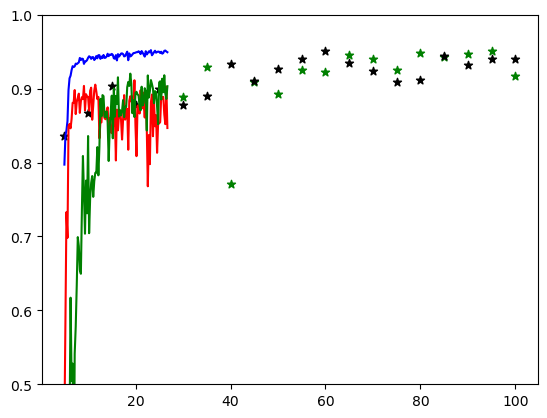

In [88]:
import matplotlib.pyplot as plt
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  first_log], color = "blue" )
# plt.plot([5*x for x in range(1, 21)], [ x[1] for x in  log] )
# plt.plot(np.arange(0, 101), [ x[1] for x in  second_performance_log] )
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  second_log] , color = "red" )
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(1,101)], [ x[1] for x in  third_log] , color = "green" )
# plt.axhline(0.94)
# plt.scatter([ 35, 40, 50, 75, 100],[0.9274666026714148,0.9286135371053348,0.9390303120950066,0.9415833068610072,0.9481415809596864], color = "red" , marker = "*" )
plt.scatter(train_fractions*100,  [0.8892, 0.9293, 0.7709, 0.9095, 0.8927, 0.9245, 0.9222, 0.9459, 0.9404, 0.9258, 0.9476, 0.9421, 0.9466, 0.9502, 0.9169] , marker = "*" , color = "green")
catx = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
catr2 = [0.8354,0.8666,0.9033,0.8784,0.9001,0.8773,0.8902,0.9336,0.9097,0.9270,0.9403,0.9503,0.9349,0.9238,0.9083,0.9116,0.9447,0.9322,0.9405,0.9404]
plt.scatter([x* 100 for x in catx] , catr2, marker = "*", color = "black")
plt.ylim(0.5,1)
# 25 % Initial Test MSE: 0.24229746295191884, R2: 0.8516043708914969
# 35 % Initial Test MSE: 0.11843110378372088, R2: 0.9274666026714148
# 40 % Initial Test MSE: 0.11655841181037568, R2: 0.9286135371053348
# 50%  Initial Test MSE: 0.09955010659747054, R2: 0.9390303120950066
# 75 % Initial Test MSE: 0.0953816269835651, R2: 0.9415833068610072
# 100% Initial Test MSE: 0.08467340609458346, R2: 0.9481415809596864


(0.8, 1.0)

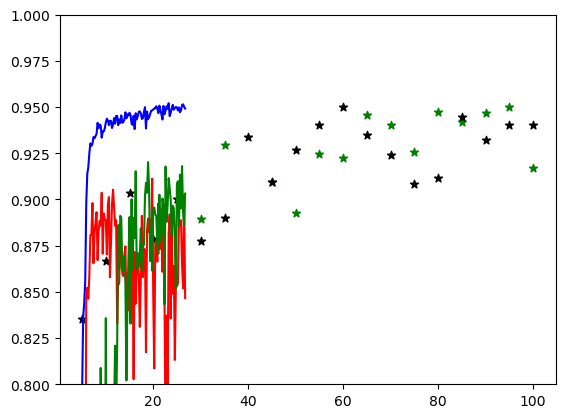

In [89]:
import matplotlib.pyplot as plt
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  first_log], color = "blue" )
# plt.plot([5*x for x in range(1, 21)], [ x[1] for x in  log] )
# plt.plot(np.arange(0, 101), [ x[1] for x in  second_performance_log] )
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  second_log] , color = "red" )
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(1,101)], [ x[1] for x in  third_log] , color = "green" )
# plt.axhline(0.94)
# plt.scatter([ 35, 40, 50, 75, 100],[0.9274666026714148,0.9286135371053348,0.9390303120950066,0.9415833068610072,0.9481415809596864], color = "red" , marker = "*" )
plt.scatter(train_fractions*100,  [0.8892, 0.9293, 0.7709, 0.9095, 0.8927, 0.9245, 0.9222, 0.9459, 0.9404, 0.9258, 0.9476, 0.9421, 0.9466, 0.9502, 0.9169] , marker = "*" , color = "green")
catx = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
catr2 = [0.8354,0.8666,0.9033,0.8784,0.9001,0.8773,0.8902,0.9336,0.9097,0.9270,0.9403,0.9503,0.9349,0.9238,0.9083,0.9116,0.9447,0.9322,0.9405,0.9404]
plt.scatter([x* 100 for x in catx] , catr2, marker = "*", color = "black")
plt.ylim(0.8,1)
# 25 % Initial Test MSE: 0.24229746295191884, R2: 0.8516043708914969
# 35 % Initial Test MSE: 0.11843110378372088, R2: 0.9274666026714148
# 40 % Initial Test MSE: 0.11655841181037568, R2: 0.9286135371053348
# 50%  Initial Test MSE: 0.09955010659747054, R2: 0.9390303120950066
# 75 % Initial Test MSE: 0.0953816269835651, R2: 0.9415833068610072
# 100% Initial Test MSE: 0.08467340609458346, R2: 0.9481415809596864


In [81]:
fourth_log

[(0.1356917597722783, 0.9168952748785368)]

* 확대

(0.8, 1.0)

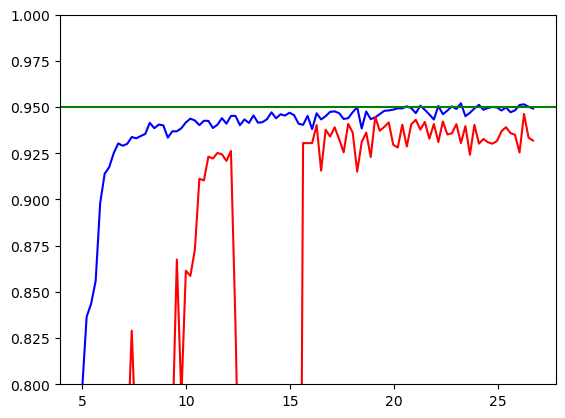

In [44]:
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  first_log], color = "blue" )
# plt.plot([5*x for x in range(1, 21)], [ x[1] for x in  log] )
# plt.plot(np.arange(0, 101), [ x[1] for x in  second_performance_log] )
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  second_log] , color = "red" )
# plt.axhline(0.94)
# plt.scatter([ 35, 40, 50, 75, 100],[0.9274666026714148,0.9286135371053348,0.9390303120950066,0.9415833068610072,0.9481415809596864], color = "red" , marker = "*" )

plt.axhline(y  =max( [ x[1] for x in  first_log]) - 0.002, color = 'green')
# 25 % Initial Test MSE: 0.24229746295191884, R2: 0.8516043708914969
# 35 % Initial Test MSE: 0.11843110378372088, R2: 0.9274666026714148
# 40 % Initial Test MSE: 0.11655841181037568, R2: 0.9286135371053348
# 50%  Initial Test MSE: 0.09955010659747054, R2: 0.9390303120950066
# 75 % Initial Test MSE: 0.0953816269835651, R2: 0.9415833068610072
# 100% Initial Test MSE: 0.08467340609458346, R2: 0.9481415809596864
plt.ylim(0.80, 1)